In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [193]:
df= pd.read_csv('train.csv')


In [141]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [142]:
df.shape

(891, 12)

# Outlier Detection

In [143]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over dataframe
    for col in features:

        # Find 1st Quartile
        Q1 = np.percentile(df[col],25)

        # Find 3rd Quartile
        Q3 = np.percentile(df[col],75)

        # Find InterQuartile Range
        IQR = Q3 - Q1

        # Setting outlier step to 1.5
        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # appending indices
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    
    # outlier_indices {'112':4,'544':5,'1123':1}
    
    multiple_outliers = list(k for k,v in outlier_indices.items() if v>n)

    return multiple_outliers

outliers_to_drop = detect_outliers(df,2,['Age','SibSp','Parch','Fare'])

In [144]:
outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [145]:
df.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [146]:
df = df.drop(outliers_to_drop,axis=0).reset_index(drop=True)
df.shape


(881, 12)

# Feature Engineering

In [147]:
df_len = len(df)

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


#### Checking for missing values

In [149]:
df.fillna(np.nan,inplace =True)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

### Feature Analysis

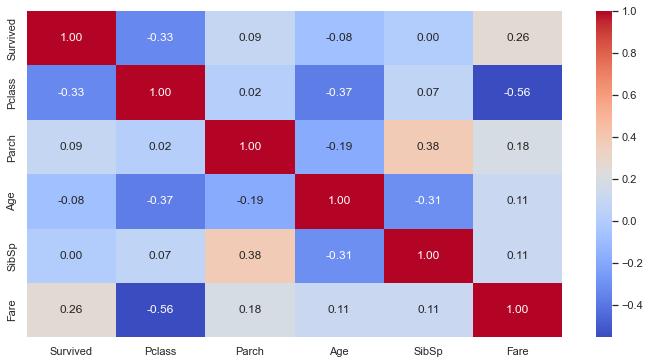

In [150]:
plt.figure(figsize=(12,6))
sns.heatmap(df[['Survived', 'Pclass', 'Parch','Age', 'SibSp','Fare']].corr(),
           annot=True,
           cmap='coolwarm',
           fmt='.2f');

1. Fare is having correlation with Pclass and Survived.
2. Pclass is having correation with Fare ,Survived and age.
3. Sibsp and Parch are correlated

#### Explore SibSp 

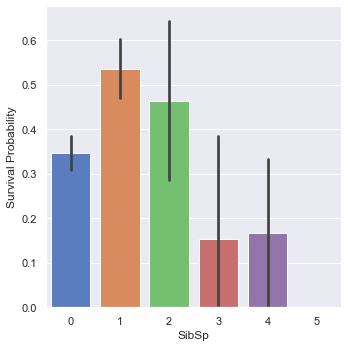

In [151]:
g =sns.factorplot(x = 'SibSp' ,y ='Survived',data = df,kind='bar',palette ='muted')
g.set_ylabels('Survival Probability')

1. More SibSp less survival
2. Single passengers and SibSp = 1,2 are having more survival rate 
than SibSp>2

#### Explore Parch

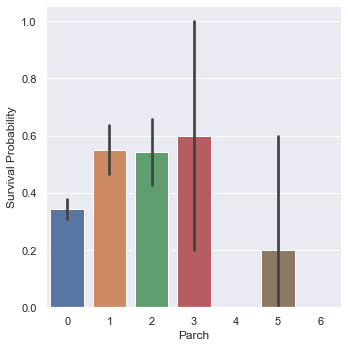

In [152]:
g = sns.factorplot(x ='Parch',y='Survived',data=df,kind = 'bar')
g.set_ylabels('Survival Probability')

1. Smaller families have higher chance of Survival
* Single - 0
* Small  - 1,2
* Medium - 3,4
* Large - 5,6

#### Explore Age

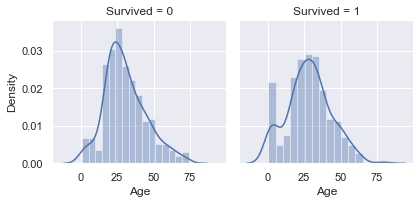

In [153]:
g = sns.FacetGrid(df,col='Survived')
g.map(sns.distplot,'Age')

1. Age distribution is gaussian in nature
2. Peaks indicate that younger population survived more

#### Explore Fare

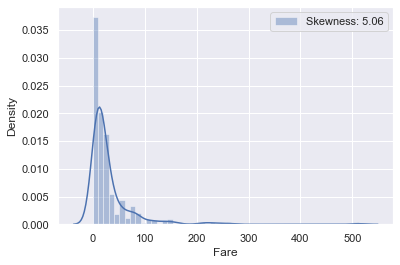

In [154]:
g=sns.distplot(df['Fare'],label='Skewness: %.2f'%(df['Fare'].skew()))
g.legend()

#### Log transformation to remove the skew

In [155]:
df['Fare']=df['Fare'].map(lambda x:np.log(x) if x>0 else 0)

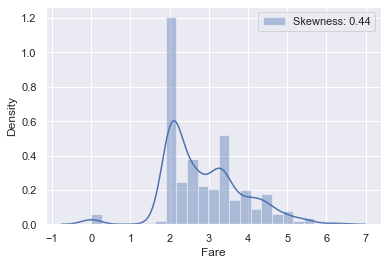

In [156]:
g = sns.distplot(df['Fare'],label='Skewness: %.2f'%(df['Fare'].skew()))
g = g.legend()

### Categorical Columns

#### Explore Sex

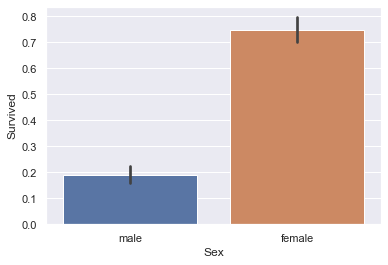

In [157]:
g = sns.barplot(x='Sex',y='Survived',data=df)

In [158]:
df[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


#### Explore PClass

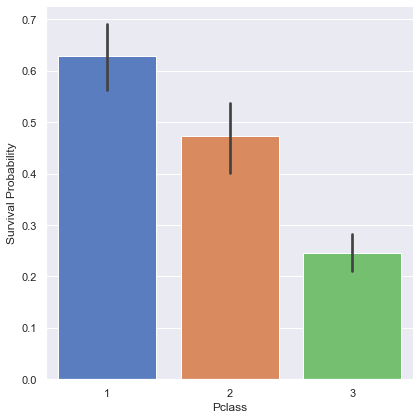

In [159]:
g = sns.factorplot(x='Pclass',y='Survived',data=df,kind='bar',palette='muted',size=6)
g.set_ylabels('Survival Probability')

Survival Prob (Pclass = 1) > Survival Prob (Pclass = 2) > Survival Prob (Pclass = 3)

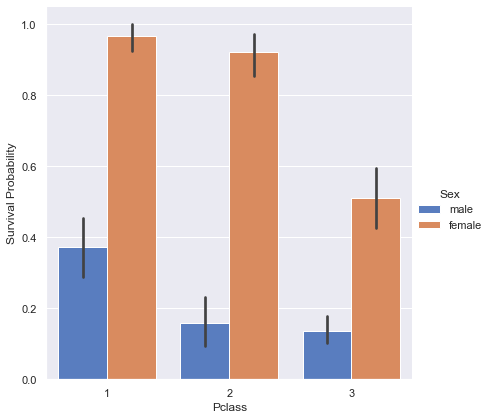

In [160]:
g = sns.factorplot(x='Pclass',y='Survived',data=df,kind='bar',hue='Sex',palette='muted',size=6)
g.set_ylabels('Survival Probability')

#### Exploring Embarked

In [161]:
df['Embarked'].isnull().sum()

2

In [162]:
df['Embarked'].value_counts()

S    634
C    168
Q     77
Name: Embarked, dtype: int64

* S - Southampton
* C - Cherbourg
* Q - Queenstown

In [163]:
df['Embarked'].fillna('S',inplace=True)

In [164]:
df['Embarked'].isnull().sum()

0

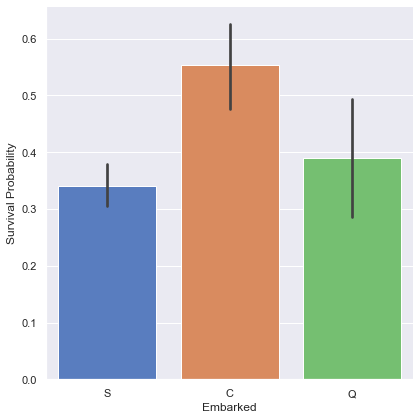

In [165]:
g = sns.factorplot(x = 'Embarked',
                   y = 'Survived',
                   data = df,
                  kind = 'bar',
                   size=6 ,
                   palette = 'muted')

g.set_ylabels('Survival Probability')

1. Highest Prob. of survival is of people who embarked from Cherbourg 

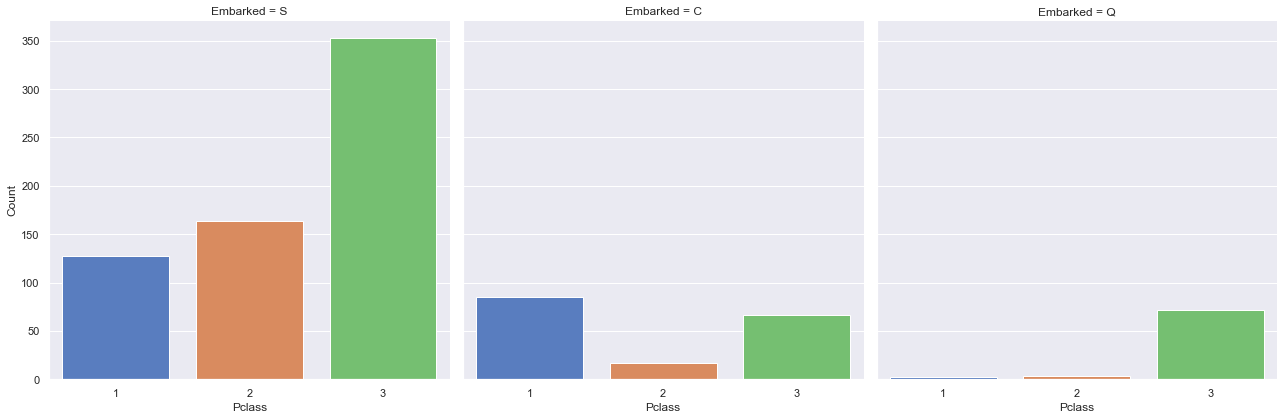

In [166]:
g = sns.factorplot(x = 'Pclass',
                   col = 'Embarked',
                   data = train,
                   kind = 'count',
                   size = 6,
                   palette = 'muted')

g = g.set_ylabels('Count')

<AxesSubplot:>

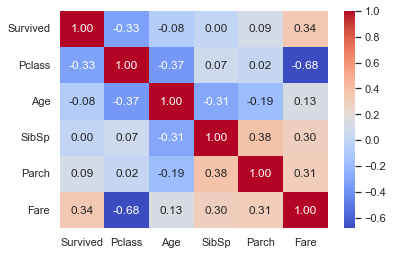

In [167]:
sns.heatmap(df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare']].corr(),
            annot=True,
            fmt='.2f',
            cmap='coolwarm'
           )

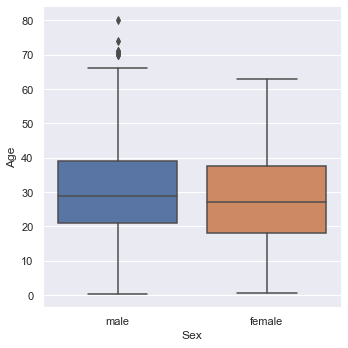

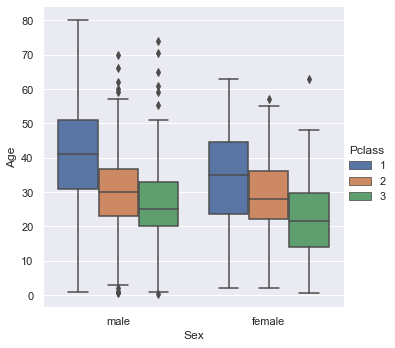

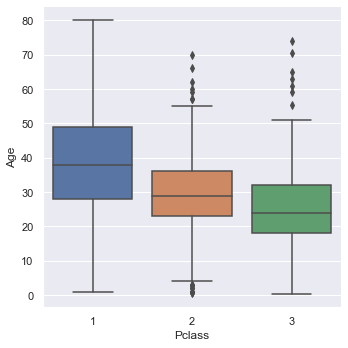

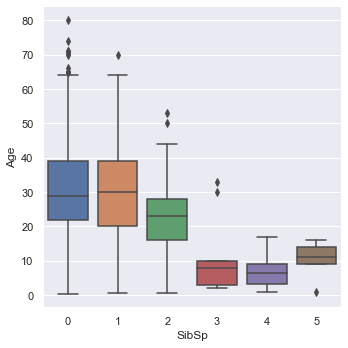

In [168]:
g = sns.factorplot(x='Sex',y='Age',data=df,kind='box')
g = sns.factorplot(x='Sex',y='Age',hue='Pclass',data=df,kind='box')
g = sns.factorplot(x='Pclass',y='Age',data=df,kind='box')
g = sns.factorplot(x='SibSp',y='Age',data=df,kind='box')

In [169]:
index_nan = list(df['Age'][df['Age'].isnull()].index)

age_median = df['Age'].median()

for i in index_nan:
    
    age_pred = df['Age'][(df['SibSp'] == df.iloc[i]['SibSp'])
                         & (df['Parch'] == df.iloc[i]['Parch'])
                         & (df['Pclass'] == df.iloc[i]['Pclass'])].median()
    
    if not np.isnan(age_pred):
        df['Age'].iloc[i] = age_pred
    else:
        df['Age'].iloc[i] = age_median

In [170]:
df['Age'].isnull().sum()

0

#### Exploring Name

In [171]:
df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [172]:

df['Title']=[s.split(',')[1].strip().split('.')[0] for s in df['Name']]
df['Title'].value_counts()

Mr              513
Miss            177
Mrs             125
Master           39
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

#### Rare Label imputation

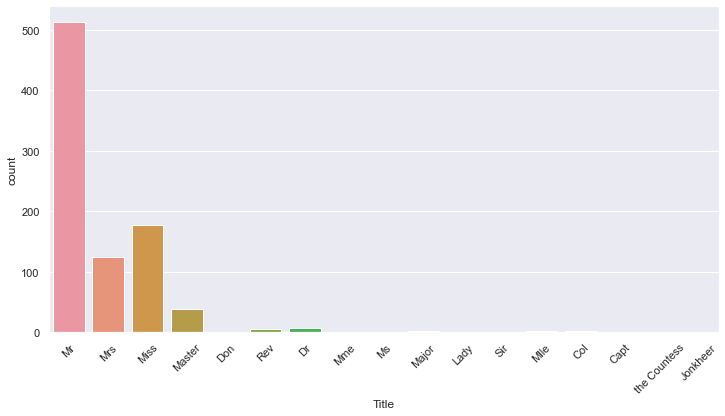

In [173]:
plt.figure(figsize=(12,6))
g = sns.countplot(x='Title',data=df)
g = plt.setp(g.get_xticklabels(),rotation=45)

In [174]:
df['Title'] = df['Title'].replace(['Don','Rev','Dr','Mme',
                                   'Major','Lady','Sir','Mlle',
                                   'Col','Capt','the Countess',
                                   'Jonkheer','Dona'],'Rare')

df['Title'] = df['Title'].map({'Mr':0,"Mrs":1,'Miss':1,'Ms':1,'Master':2,'Rare':3})

In [175]:
df['Title'].value_counts()

0    513
1    303
2     39
3     26
Name: Title, dtype: int64

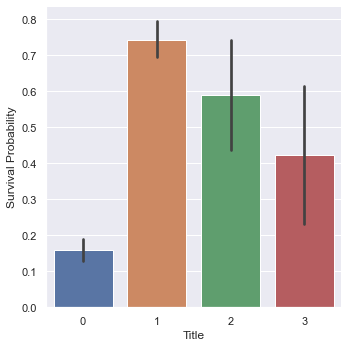

In [176]:
g = sns.factorplot(y='Survived',x='Title',data=df,kind='bar')
g.set_ylabels('Survival Probability')

P(Survival) 1 > 2 > 3

#### Family Size

Parch + Sibsp + 1 = Family

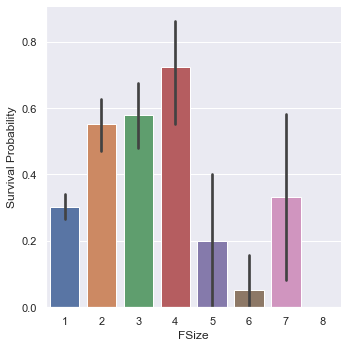

In [177]:
df['FSize'] = df['Parch']+df['SibSp']+1

g = sns.factorplot(y='Survived',x='FSize',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')

In [178]:
df['Single'] = df['FSize'].map(lambda x: 1 if x==1 else 0)
df['SmallF'] = df['FSize'].map(lambda x: 1 if x==2 else 0)
df['MedF'] = df['FSize'].map(lambda x: 1 if 3 <= x <=4 else 0)
df['LargeF'] = df['FSize'].map(lambda x: 1 if x>4 else 0)

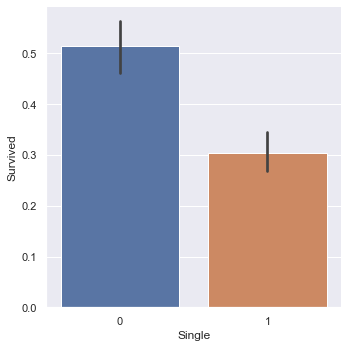

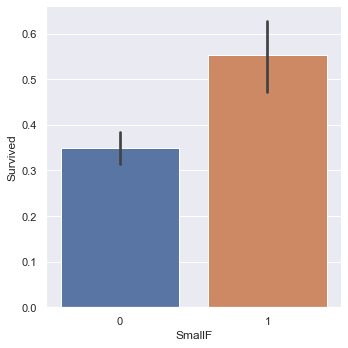

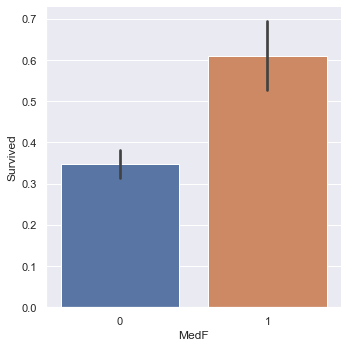

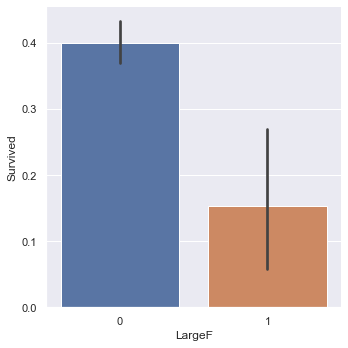

In [179]:
g = sns.factorplot(y='Survived',x='Single',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='SmallF',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='MedF',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='LargeF',data=df,kind='bar')

In [186]:
df.replace({'Sex':{'male':0,'female':1},'Embarked':{'S':0,'C':1,'Q':2}},inplace=True)

# Modelling

In [187]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FSize',
       'Single', 'SmallF', 'MedF', 'LargeF'],
      dtype='object')

In [190]:
X = df.drop(columns=['PassengerId','Name','Ticket','Survived','Title','FSize',
       'Single', 'SmallF', 'MedF', 'LargeF','Cabin'],axis=1)
y = df['Survived']

In [191]:
print(X)

     Pclass  Sex   Age  SibSp  Parch      Fare  Embarked
0         3    0  22.0      1      0  1.981001         0
1         1    1  38.0      1      0  4.266662         1
2         3    1  26.0      0      0  2.070022         0
3         1    1  35.0      1      0  3.972177         0
4         3    0  35.0      0      0  2.085672         0
..      ...  ...   ...    ...    ...       ...       ...
876       2    0  27.0      0      0  2.564949         0
877       1    1  19.0      0      0  3.401197         0
878       3    1  13.5      1      2  3.154870         0
879       1    0  26.0      0      0  3.401197         1
880       3    0  32.0      0      0  2.047693         2

[881 rows x 7 columns]


In [194]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [195]:
print(X.shape,X_train.shape,X_test.shape)

(881, 7) (704, 7) (177, 7)


In [196]:
lr = LogisticRegression()

In [197]:
lr.fit(X_train,y_train)

LogisticRegression()

In [198]:
X_train_prediction = lr.predict(X_train)
print(X_train_prediction)

[1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1
 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0
 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1
 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0
 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0
 0 0 0 0 0 0 1 1 0 1 1 1 

In [199]:
training_accuracy = accuracy_score(y_train,X_train_prediction)
print('Accuracy score of training data : ', training_accuracy)

Accuracy score of training data :  0.796875


In [200]:
X_test_prediction = lr.predict(X_test)
print(X_test_prediction)

[1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1
 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1]


In [201]:
test_accuracy = accuracy_score(y_test,X_test_prediction)
print('Accuracy score of test data : ', test_accuracy)

Accuracy score of test data :  0.8022598870056498


In [204]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

65.62

In [206]:
# KNN or K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

87.36

In [207]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

76.99

In [208]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

74.72

In [209]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

79.83

In [210]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

73.58

In [211]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

98.44

In [212]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

98.44

# Model Evaluation

In [214]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,98.44
7,Decision Tree,98.44
1,KNN,87.36
6,Linear SVC,79.83
3,Naive Bayes,76.99
4,Perceptron,74.72
5,Stochastic Gradient Decent,73.58
0,Support Vector Machines,65.62
